# Empirical Comparison of Machine Learning Classifiers

This notebook compares Logistic Regression, SVM, and Random Forest classifiers on three datasets: Spambase, Adult, and Mushroom

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [10]:
#  parameters
partitions = [
    (0.2, 0.8),
    (0.5, 0.5),
    (0.8, 0.2),
]

num_trials = 3
CV_folds = 3

# Loading all Datasets

In [11]:
def load_spambase():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data"
    
    column_names = [
        'word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d',
        'word_freq_our', 'word_freq_over', 'word_freq_remove', 'word_freq_internet',
        'word_freq_order', 'word_freq_mail', 'word_freq_receive', 'word_freq_will',
        'word_freq_people', 'word_freq_report', 'word_freq_addresses',
        'word_freq_free', 'word_freq_business', 'word_freq_email', 'word_freq_you',
        'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000',
        'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george',
        'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet',
        'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85',
        'word_freq_technology', 'word_freq_1999', 'word_freq_parts',
        'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting',
        'word_freq_original', 'word_freq_project', 'word_freq_re',
        'word_freq_edu', 'word_freq_table', 'word_freq_conference',
        'char_freq_;', 'char_freq_(', 'char_freq_[', 'char_freq_!', 'char_freq_$',
        'char_freq_#', 'capital_run_length_average',
        'capital_run_length_longest', 'capital_run_length_total',
        'label'
    ]
    
    df = pd.read_csv(url, header = None, names = column_names)
    X = df.drop("label", axis = 1).values
    y = df["label"].values
    
    return X, y, "Spambase"


def load_adult():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
    
    column_names = [
        "age", "workclass", "fnlwgt", "education", "education_num",
        "marital_status", "occupation", "relationship", "race", "sex",
        "capital_gain", "capital_loss", "hours_per_week", "native_country",
        "income"
    ]
    
    df = pd.read_csv(
        url,
        header = None,
        names = column_names,
        skipinitialspace = True
    )
    
    def convert_income(value):
        if value == "<=50K":
            return 0
        else:
            return 1

    df["income"] = df["income"].apply(convert_income)
    
    numeric_features = [
        "age", "fnlwgt", "education_num",
        "capital_gain", "capital_loss", "hours_per_week"
    ]
    
    categorical_features = [
        "workclass", "education", "marital_status",
        "occupation", "relationship", "race", "sex", "native_country"
    ]
    
    X = df[numeric_features + categorical_features]
    y = df["income"].values
    
    return X, y, "Adult", numeric_features, categorical_features


def load_mushroom():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
    
    column_names = [
        "class", "cap_shape", "cap_surface", "cap_color", "bruises", "odor",
        "gill_attachment", "gill_spacing", "gill_size", "gill_color",
        "stalk_shape", "stalk_root", "stalk_surface_above_ring",
        "stalk_surface_below_ring", "stalk_color_above_ring",
        "stalk_color_below_ring", "veil_type", "veil_color", "ring_number",
        "ring_type", "spore_print_color", "population", "habitat"
    ]
    
    df = pd.read_csv(url, header = None, names = column_names)
    
    def convert_class(value):
        if value == "p":
            return 1
        else:
            return 0
    
    df["class"] = df["class"].apply(convert_class)
    
    X = df.drop("class", axis = 1)
    y = df["class"].values
    
    categorical_features = X.columns.tolist()
    
    return X, y, "Mushroom", categorical_features

# Spambase experiment

In [12]:
X_spam, y_spam, dataset_name_spam = load_spambase()
print(f"{dataset_name_spam} shape: {X_spam.shape}")

# pipelines
log_reg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter = 2000))
])

svm_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC())
])

rf_pipeline = Pipeline([
    ("clf", RandomForestClassifier())
])

# param grids
classifiers_spam = {
    "LogisticRegression": (
        log_reg_pipeline,
        {
            "clf__C": [0.01, 0.1, 1, 10, 100],
            "clf__penalty": ["l2"],
            "clf__solver": ["lbfgs"],
        },
    ),
    "SVM_RBF": (
        svm_pipeline,
        {
            "clf__C": [0.1, 1, 10, 100],
            "clf__gamma": [0.001, 0.01, 0.1, 1],
        },
    ),
    "RandomForest": (
        rf_pipeline,
        {
            "clf__n_estimators": [50, 100, 200],
            "clf__max_depth": [None, 10, 20, 30],
            "clf__max_features": ["sqrt", "log2"],
        },
    ),
}

# running experiments
results_spam = []

for clf_name, (pipeline, param_grid) in classifiers_spam.items():
    for train_size, test_size in partitions:
        for trial in range(1, num_trials + 1):

            X_train, X_test, y_train, y_test = train_test_split(
                X_spam,
                y_spam,
                train_size = train_size,
                test_size = test_size,
                stratify = y_spam,
            )

            grid = GridSearchCV(
                estimator = pipeline,
                param_grid = param_grid,
                scoring = "accuracy",
                cv = CV_folds,
                n_jobs = -1,
            )
            grid.fit(X_train, y_train)

            best_model = grid.best_estimator_

            y_train_pred = best_model.predict(X_train)
            y_test_pred = best_model.predict(X_test)

            results_spam.append({
                "dataset": dataset_name_spam,
                "classifier": clf_name,
                "train_size": train_size,
                "test_size": test_size,
                "trial": trial,
                "train_accuracy": accuracy_score(y_train, y_train_pred),
                "val_accuracy_cv_mean": grid.best_score_,
                "test_accuracy": accuracy_score(y_test, y_test_pred),
                "best_params": grid.best_params_,
            })

results_spam_df = pd.DataFrame(results_spam)


summary_spam = (
    results_spam_df
    .groupby(["dataset", "classifier", "train_size", "test_size"])
    [["train_accuracy", "val_accuracy_cv_mean", "test_accuracy"]]
    .mean()
    .reset_index()
)

print("\nSpambase summary (mean over trials):")
print(summary_spam)

Spambase shape: (4601, 57)

Spambase summary (mean over trials):
    dataset          classifier  train_size  test_size  train_accuracy  \
0  Spambase  LogisticRegression         0.2        0.8        0.934058   
1  Spambase  LogisticRegression         0.5        0.5        0.929420   
2  Spambase  LogisticRegression         0.8        0.2        0.932065   
3  Spambase        RandomForest         0.2        0.8        0.994565   
4  Spambase        RandomForest         0.5        0.5        0.996232   
5  Spambase        RandomForest         0.8        0.2        0.999094   
6  Spambase             SVM_RBF         0.2        0.8        0.948551   
7  Spambase             SVM_RBF         0.5        0.5        0.952609   
8  Spambase             SVM_RBF         0.8        0.2        0.959330   

   val_accuracy_cv_mean  test_accuracy  
0              0.906517       0.909807  
1              0.914641       0.924236  
2              0.925725       0.927253  
3              0.928631       

# Adult experiment

In [13]:
X_adult, y_adult, dataset_name_adult, numeric_features, categorical_features = load_adult()
print(f"{dataset_name_adult} shape: {X_adult.shape}")


preprocessor_adult = ColumnTransformer(
    transformers = [
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown = "ignore"), categorical_features),
    ]
)

# pipelines
log_reg_pipeline = Pipeline([
    ("preprocess", preprocessor_adult),
    ("clf", LogisticRegression(max_iter = 2000))
])

svm_pipeline = Pipeline([
    ("preprocess", preprocessor_adult),
    ("clf", SVC())
])

rf_pipeline = Pipeline([
    ("preprocess", preprocessor_adult),
    ("clf", RandomForestClassifier())
])

# param grids
classifiers_adult = {
    "LogisticRegression": (
        log_reg_pipeline,
        {
            "clf__C": [0.01, 0.1, 1, 10],
            "clf__penalty": ["l2"],
            "clf__solver": ["lbfgs"],
        },
    ),
    "SVM_RBF": (
        svm_pipeline,
        {
            "clf__C": [1, 10],
            "clf__gamma": [0.001, 0.01],
        },
    ),
    "RandomForest": (
        rf_pipeline,
        {
            "clf__n_estimators": [100, 200],
            "clf__max_depth": [None, 10, 20],
            "clf__max_features": ["sqrt", "log2"],
        },
    ),
}

# running experiments
results_adult = []

for clf_name, (pipeline, param_grid) in classifiers_adult.items():
    for train_size, test_size in partitions:
        for trial in range(1, num_trials + 1):


            X_train, X_test, y_train, y_test = train_test_split(
                X_adult,
                y_adult,
                train_size = train_size,
                test_size = test_size,
                stratify = y_adult,
            )

            grid = GridSearchCV(
                estimator = pipeline,
                param_grid = param_grid,
                scoring = "accuracy",
                cv = CV_folds,
                n_jobs = -1,
            )
            grid.fit(X_train, y_train)

            best_model = grid.best_estimator_

            # Evaluate on train and test
            y_train_pred = best_model.predict(X_train)
            y_test_pred = best_model.predict(X_test)

            results_adult.append({
                "dataset": dataset_name_adult,
                "classifier": clf_name,
                "train_size": train_size,
                "test_size": test_size,
                "trial": trial,
                "train_accuracy": accuracy_score(y_train, y_train_pred),
                "val_accuracy_cv_mean": grid.best_score_,
                "test_accuracy": accuracy_score(y_test, y_test_pred),
                "best_params": grid.best_params_,
            })

# Results DataFrame
results_adult_df = pd.DataFrame(results_adult)
print("\nFinished all Adult runs. Head of results:")
print(results_adult_df.head())

# Summary
summary_adult = (
    results_adult_df
    .groupby(["dataset", "classifier", "train_size", "test_size"])
    [["train_accuracy", "val_accuracy_cv_mean", "test_accuracy"]]
    .mean()
    .reset_index()
)

print("\nAdult summary (mean over trials):")
print(summary_adult)

Adult shape: (32561, 14)


Exception ignored in: <function ResourceTracker.__del__ at 0x10727dbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes



Finished all Adult runs. Head of results:
  dataset          classifier  train_size  test_size  trial  train_accuracy  \
0   Adult  LogisticRegression         0.2        0.8      1        0.856265   
1   Adult  LogisticRegression         0.2        0.8      2        0.852733   
2   Adult  LogisticRegression         0.2        0.8      3        0.856419   
3   Adult  LogisticRegression         0.5        0.5      1        0.853747   
4   Adult  LogisticRegression         0.5        0.5      2        0.853256   

   val_accuracy_cv_mean  test_accuracy  \
0              0.848742       0.851165   
1              0.848127       0.849130   
2              0.852427       0.848708   
3              0.850860       0.851975   
4              0.851167       0.851668   

                                         best_params  
0  {'clf__C': 1, 'clf__penalty': 'l2', 'clf__solv...  
1  {'clf__C': 10, 'clf__penalty': 'l2', 'clf__sol...  
2  {'clf__C': 1, 'clf__penalty': 'l2', 'clf__solv...  
3  {'clf_

# Mushroom experiment

In [14]:
X_mush, y_mush, dataset_name_mush, categorical_features = load_mushroom()
print(f"{dataset_name_mush} shape: {X_mush.shape}")


preprocessor_mush = ColumnTransformer(
    transformers = [
        ("cat", OneHotEncoder(handle_unknown = "ignore"), categorical_features)
    ]
)

# pipelines
log_reg_pipeline = Pipeline([
    ("preprocess", preprocessor_mush),
    ("clf", LogisticRegression(max_iter = 2000))
])

svm_pipeline = Pipeline([
    ("preprocess", preprocessor_mush),
    ("clf", SVC())
])

rf_pipeline = Pipeline([
    ("preprocess", preprocessor_mush),
    ("clf", RandomForestClassifier())
])

# param grids
classifiers_mush = {
    "LogisticRegression": (
        log_reg_pipeline,
        {
            "clf__C": [0.01, 0.1, 1, 10],
            "clf__penalty": ["l2"],
            "clf__solver": ["lbfgs"],
        },
    ),
    "SVM_RBF": (
        svm_pipeline,
        {
            "clf__C": [1, 10],
            "clf__gamma": [0.001, 0.01],
        },
    ),
    "RandomForest": (
        rf_pipeline,
        {
            "clf__n_estimators": [100, 200],
            "clf__max_depth": [None, 10, 20],
            "clf__max_features": ["sqrt", "log2"],
        },
    ),
}

# running experiments
results_mush = []

for clf_name, (pipeline, param_grid) in classifiers_mush.items():
    for train_size, test_size in partitions:
        for trial in range(1, num_trials + 1):

            X_train, X_test, y_train, y_test = train_test_split(
                X_mush,
                y_mush,
                train_size = train_size,
                test_size = test_size,
                stratify = y_mush,
            )

            grid = GridSearchCV(
                estimator = pipeline,
                param_grid = param_grid,
                scoring = "accuracy",
                cv = CV_folds,
                n_jobs = -1,
            )
            grid.fit(X_train, y_train)
            
            best_model = grid.best_estimator_
            
            # Evaluate on train and test
            y_train_pred = best_model.predict(X_train)
            y_test_pred = best_model.predict(X_test)
            
            results_mush.append({
                "dataset": dataset_name_mush,
                "classifier": clf_name,
                "train_size": train_size,
                "test_size": test_size,
                "trial": trial,
                "train_accuracy": accuracy_score(y_train, y_train_pred),
                "val_accuracy_cv_mean": grid.best_score_,
                "test_accuracy": accuracy_score(y_test, y_test_pred),
                "best_params": grid.best_params_,
            })

results_mush_df = pd.DataFrame(results_mush)
print("\nFinished all Mushroom runs. Head of results:")
print(results_mush_df.head())

# Create summary
summary_mush = (results_mush_df
                .groupby(["dataset", "classifier", "train_size", "test_size"])
                [["train_accuracy", "val_accuracy_cv_mean", "test_accuracy"]]
                .mean()
                .reset_index())

print("\nMushroom summary (mean over 3 trials):")
print(summary_mush)

Mushroom shape: (8124, 22)

Finished all Mushroom runs. Head of results:
    dataset          classifier  train_size  test_size  trial  train_accuracy  \
0  Mushroom  LogisticRegression         0.2        0.8      1        1.000000   
1  Mushroom  LogisticRegression         0.2        0.8      2        1.000000   
2  Mushroom  LogisticRegression         0.2        0.8      3        0.999384   
3  Mushroom  LogisticRegression         0.5        0.5      1        1.000000   
4  Mushroom  LogisticRegression         0.5        0.5      2        1.000000   

   val_accuracy_cv_mean  test_accuracy  \
0              0.997539       0.998769   
1              0.998769       1.000000   
2              0.998770       0.998923   
3              0.999508       1.000000   
4              1.000000       1.000000   

                                         best_params  
0  {'clf__C': 10, 'clf__penalty': 'l2', 'clf__sol...  
1  {'clf__C': 10, 'clf__penalty': 'l2', 'clf__sol...  
2  {'clf__C': 1, 'clf_

# Combine All Results

In [15]:

all_summaries = pd.concat(
    [summary_spam, summary_adult, summary_mush],
    ignore_index=True
)

print("Combined summary across all datasets:")
print(all_summaries)


Combined summary across all datasets:
     dataset          classifier  train_size  test_size  train_accuracy  \
0   Spambase  LogisticRegression         0.2        0.8        0.934058   
1   Spambase  LogisticRegression         0.5        0.5        0.929420   
2   Spambase  LogisticRegression         0.8        0.2        0.932065   
3   Spambase        RandomForest         0.2        0.8        0.994565   
4   Spambase        RandomForest         0.5        0.5        0.996232   
5   Spambase        RandomForest         0.8        0.2        0.999094   
6   Spambase             SVM_RBF         0.2        0.8        0.948551   
7   Spambase             SVM_RBF         0.5        0.5        0.952609   
8   Spambase             SVM_RBF         0.8        0.2        0.959330   
9      Adult  LogisticRegression         0.2        0.8        0.855139   
10     Adult  LogisticRegression         0.5        0.5        0.854115   
11     Adult  LogisticRegression         0.8        0.2       

# Visulization

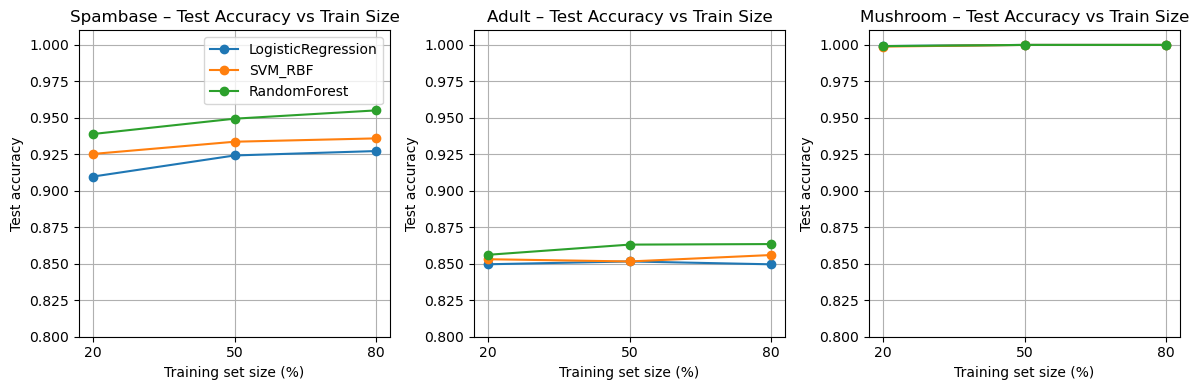

Exception ignored in: <function ResourceTracker.__del__ at 0x1060d1bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x111065bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x107069bc0>
Traceback (most recent call last

In [16]:
# Convert  to percentages
train_size_map = {0.2: 20, 0.5: 50, 0.8: 80}
plot_df = all_summaries.copy()
plot_df["train_percent"] = plot_df["train_size"].map(train_size_map)

datasets = ["Spambase", "Adult", "Mushroom"]
classifiers = ["LogisticRegression", "SVM_RBF", "RandomForest"]

plt.figure(figsize = (12, 4))

for i, ds in enumerate(datasets, 1):
    ax = plt.subplot(1, 3, i)
    ds_df = plot_df[plot_df["dataset"] == ds]
    
    for clf in classifiers:
        sub = ds_df[ds_df["classifier"] == clf].sort_values("train_percent")
        ax.plot(
            sub["train_percent"],
            sub["test_accuracy"],
            marker = "o",
            label = clf
        )
    
    ax.set_title(f"{ds} – Test Accuracy vs Train Size")
    ax.set_xlabel("Training set size (%)")
    ax.set_ylabel("Test accuracy")
    ax.set_xticks([20, 50, 80])
    ax.set_ylim(0.8, 1.01)
    ax.grid(True)
    
    if i == 1:
        ax.legend()

plt.tight_layout()
plt.show()
